# Notes

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

plt.rcParams["figure.figsize"] = (12, 4)

# Data

In [3]:
stocks = pd.read_csv("../data/all_stocks_5yr.csv.gz", parse_dates=["date"])
stocks

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [4]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [5]:
stocks = stocks.set_index("date").groupby("Name").resample("W").mean().reset_index()
stocks

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070000,45.350000,45.000000,45.080000,1824755.00
1,A,2013-02-17,44.598000,44.878000,44.040000,44.160000,5165006.80
2,A,2013-02-24,42.255000,42.545000,41.871250,42.170000,3689833.75
3,A,2013-03-03,41.332000,41.891000,40.898000,41.480000,3985236.20
4,A,2013-03-10,42.780000,43.178000,42.518000,42.842000,2878377.80
...,...,...,...,...,...,...,...
128835,ZTS,2018-01-14,74.334000,75.013000,73.879140,74.648000,2431182.00
128836,ZTS,2018-01-21,76.302500,76.747500,75.667500,76.315000,3196819.50
128837,ZTS,2018-01-28,78.018000,78.784000,77.783000,78.548000,2780926.20
128838,ZTS,2018-02-04,78.222000,78.760000,77.396000,77.772000,3236979.20


# Sandbox

In [6]:
from tstools.forecast.models import (
    Univariate,
    Naive,
    Drift,
    Mean,
    ETS,
    ARIMA,
    AutoARIMA,
    AutoRegression,
    ScikitRegression,
)
from tstools.metrics import mae, mse

from darts.timeseries import TimeSeries
from darts.models import ( 
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA as arima_darts,
    AutoARIMA as autoarima_darts,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)
import darts.metrics

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm

from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
#data = stocks[stocks.Name.isin(["A", "AAL"])]
data = stocks[stocks.Name.isin(["A"])]
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [8]:
train = data.iloc[:-10].copy()
test = data.iloc[-10:].copy()

In [9]:
ts_train = TimeSeries.from_dataframe(train[["date", "open"]].set_index("date"))
ts_test = TimeSeries.from_dataframe(test[["date", "open"]].set_index("date"))
cov_train = TimeSeries.from_dataframe(train[["date", "close"]].set_index("date"))
cov_test = TimeSeries.from_dataframe(test[["date", "close"]].set_index("date"))

In [10]:
ts_train_endog = train.set_index("date").asfreq("W")["open"].copy()
ts_train_exog = train.set_index("date").asfreq("W")["close"].copy()
ts_test_endog = test.set_index("date").asfreq("W")["open"].copy()
ts_test_exog = test.set_index("date").asfreq("W")["close"].copy()

In [127]:
#model = Naive(time_col="date", target_col="open", regressor_cols=None, freq="W")
#model = Drift(time_col="date", target_col="open", regressor_cols=None, freq="W")
model = Mean(time_col="date", target_col="open", regressor_cols=None, freq="W")
#model = ARIMA(time_col="date", target_col="open", regressor_cols=["close"], freq="W", order=(5, 1, 0))
#model = ETS(time_col="date", target_col="open", regressor_cols=None, freq="W", trend="add", damped_trend=True)
#model = AutoRegression(time_col="date", target_col="open", regressor_cols=None, freq="W", lags=5, trend="n")
#model = AutoARIMA(time_col="date", target_col="open", regressor_cols=None, freq="W")

In [128]:
model.fit(data)

Mean(time_col='date', target_col='open', regressor_cols=None, freq='W')

In [129]:
future = model.get_future_dataframe(train, fh=10)
future = future.merge(data[["date", "close"]], on="date")
fcst = model.predict(future, conf_int=0.95)

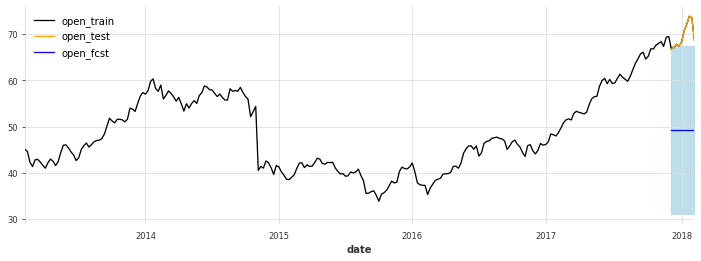

In [130]:
model.plot_fcst(fcst, train=None, test=test, plot_history=True)              

In [131]:
model.score(test, fcst, metrics=[mae, mse])

mae     20.416488
mse    423.459605
dtype: float64

In [132]:
hfcst = model.historical_forecasts(train, fh=10)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:04<00:00, 23.77it/s]


In [133]:
hfcst_tail = pd.concat([fcst.tail(1) for fcst in hfcst]).reset_index(drop=True)

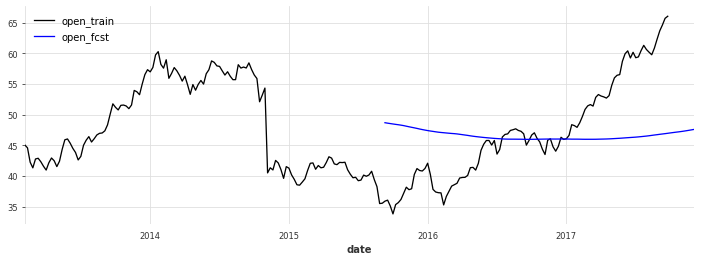

In [134]:
model.plot_fcst(hfcst_tail)

In [135]:
model.score_cv(train, hfcst, metrics=[mae, mse])

,mae,mse
0,10.196330,107.844523
1,10.450006,113.500990
2,10.888594,123.159438
3,11.436536,135.977464
4,11.855518,144.827660
...,...,...
112,18.589327,347.319605
113,18.988657,362.213531
114,19.187270,369.515267
115,19.470810,380.979399


In [136]:
model.score_cv(train, hfcst, metrics=[mae, mse], agg=np.mean)

mae     7.461068
mse    87.525129
dtype: float64